In [16]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
img = cv2.imread('./test_images/beautiful-ginger-woman-casual-purple-t-shirt-looks-with-pleased-delighted-expression-camera-poses-against-white-concrete-wall_273609-3734.avif')
img.shape

(493, 740, 3)

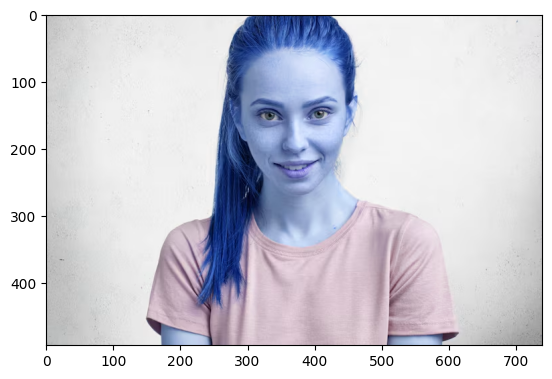

In [34]:
plt.imshow(img)

In [35]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(493, 740)

In [36]:
gray

array([[198, 189, 191, ..., 226, 225, 225],
       [196, 190, 191, ..., 226, 225, 225],
       [194, 191, 191, ..., 226, 225, 225],
       ...,
       [191, 178, 171, ..., 152, 148, 146],
       [188, 176, 170, ..., 153, 149, 148],
       [185, 176, 171, ..., 153, 145, 127]], shape=(493, 740), dtype=uint8)

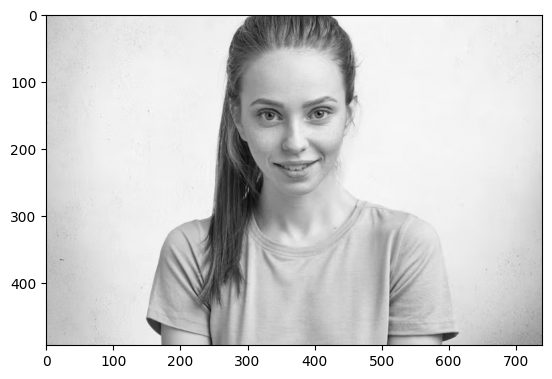

In [37]:
plt.imshow(gray, cmap='gray')

In [38]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[268,  67, 209, 209]], dtype=int32)

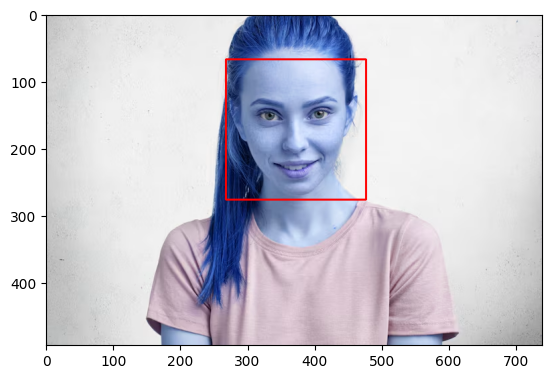

In [39]:
(x,y,w,h) = faces[0]
x,y,w,h
face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
plt.imshow(face_img)

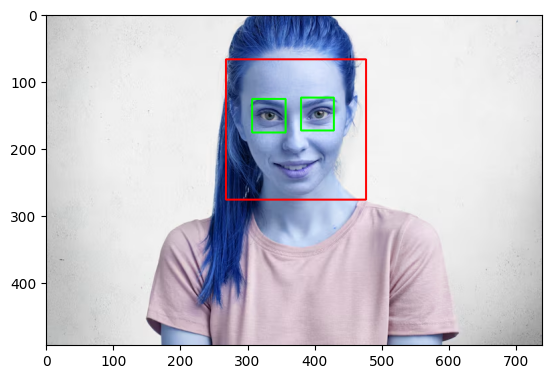

In [40]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

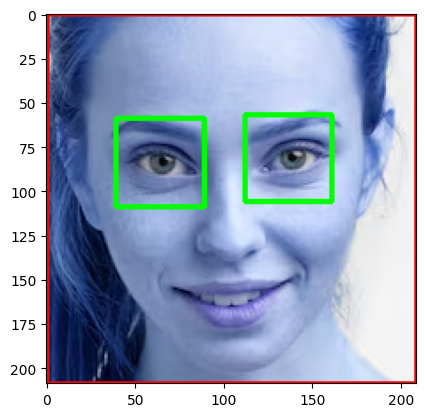

In [41]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [54]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
            

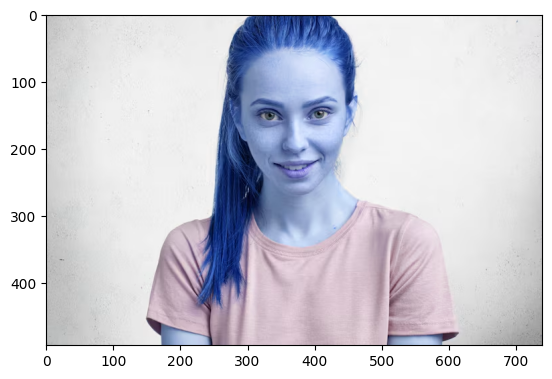

In [43]:
original_image = cv2.imread('./test_images/beautiful-ginger-woman-casual-purple-t-shirt-looks-with-pleased-delighted-expression-camera-poses-against-white-concrete-wall_273609-3734.avif')
plt.imshow(original_image)

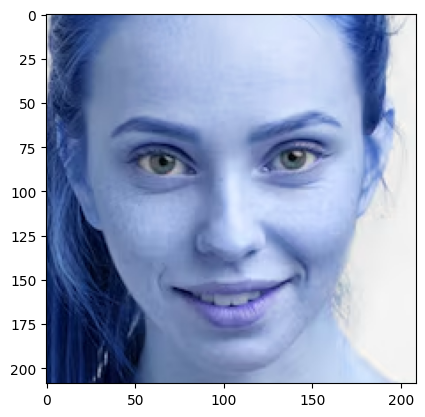

In [44]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/beautiful-ginger-woman-casual-purple-t-shirt-looks-with-pleased-delighted-expression-camera-poses-against-white-concrete-wall_273609-3734.avif')
plt.imshow(cropped_image)

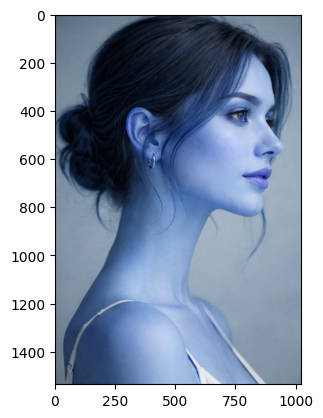

In [45]:
org_image_obstructed = cv2.imread('./test_images/anotherpic.png')
plt.imshow(org_image_obstructed)

In [46]:
cropped_image_obstructed = get_cropped_image_if_2_eyes('./test_images/anotherpic.png')
cropped_image_obstructed

In [47]:
path_to_data = './dataset/'
path_to_cr_data = "./dataset/cropped/"

In [48]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.name)

In [49]:
img_dirs

['chiara_ferragni',
 'cropped',
 'mia_khalifa',
 'belen_rodriguez',
 'iu',
 'sydney_sweeney']

In [50]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)        

In [70]:
#After running this cell, it requires a manual cleanup of the cropped images

cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    if img_dir == 'cropped':
        continue
    count = 1
    img_dir_path = os.path.join(path_to_data, img_dir)
    celebrity_name = os.path.basename(img_dir_path)
    celebrity_file_names_dict.setdefault(celebrity_name, [])
    print(celebrity_name)

    for entry in os.scandir(img_dir_path):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)

            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

            saved = cv2.imwrite(cropped_file_path, roi_color)
            if saved:
                celebrity_file_names_dict[celebrity_name].append(cropped_file_name)
            else:
                print("Failed to write:", cropped_file_path)
            count += 1

chiara_ferragni
mia_khalifa
belen_rodriguez
iu
sydney_sweeney


# Feature Engineering

In [ ]:
#checkpoint
import os

path_to_cr_data = "./dataset/cropped/"
celebrity_file_names_dict = {}

for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        files = [
            f.name for f in os.scandir(entry.path)
            if f.is_file() and f.name.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        celebrity_file_names_dict[entry.name] = sorted(files)

celebrity_file_names_dict


In [4]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    if img is None:
        return None

    imArray = img
    # convert to grayscale if needed (OpenCV loads BGR)
    if len(imArray.shape) == 3:
        imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)

    # convert to float in [0, 1]
    imArray = np.float32(imArray) / 255.0

    # compute wavelet coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    # zero out approximation coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    # reconstruct image from detail coefficients
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H = np.clip(imArray_H, 0, 1)
    imArray_H = np.uint8(imArray_H * 255)

    return imArray_H


In [8]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

NameError: name 'cropped_image' is not defined

In [9]:
celebrity_file_names_dict

{'chiara_ferragni': ['chiara_ferragni1.png',
  'chiara_ferragni10.png',
  'chiara_ferragni11.png',
  'chiara_ferragni12.png',
  'chiara_ferragni13.png',
  'chiara_ferragni14.png',
  'chiara_ferragni15.png',
  'chiara_ferragni16.png',
  'chiara_ferragni17.png',
  'chiara_ferragni18.png',
  'chiara_ferragni19.png',
  'chiara_ferragni2.png',
  'chiara_ferragni20.png',
  'chiara_ferragni21.png',
  'chiara_ferragni22.png',
  'chiara_ferragni23.png',
  'chiara_ferragni24.png',
  'chiara_ferragni25.png',
  'chiara_ferragni26.png',
  'chiara_ferragni27.png',
  'chiara_ferragni28.png',
  'chiara_ferragni29.png',
  'chiara_ferragni3.png',
  'chiara_ferragni30.png',
  'chiara_ferragni31.png',
  'chiara_ferragni32.png',
  'chiara_ferragni33.png',
  'chiara_ferragni34.png',
  'chiara_ferragni35.png',
  'chiara_ferragni36.png',
  'chiara_ferragni37.png',
  'chiara_ferragni38.png',
  'chiara_ferragni39.png',
  'chiara_ferragni4.png',
  'chiara_ferragni41.png',
  'chiara_ferragni42.png',
  'chiara_fer

In [10]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'chiara_ferragni': 0,
 'mia_khalifa': 1,
 'belen_rodriguez': 2,
 'iu': 3,
 'sydney_sweeney': 4}

In [11]:
import os
import warnings
warnings.filterwarnings("error")
X = []
y = []


for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        training_image_path = os.path.join(path_to_cr_data, celebrity_name, training_image)
        if not os.path.isfile(training_image_path):
            continue
        img = cv2.imread(training_image_path)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])


In [12]:
len(X)

200

In [13]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(200, 4096)

# Model Train

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [26]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       1.00      0.77      0.87        13
           2       0.58      1.00      0.74         7
           3       0.83      0.71      0.77         7
           4       0.67      0.57      0.62         7

    accuracy                           0.75        40
   macro avg       0.75      0.74      0.73        40
weighted avg       0.79      0.75      0.75        40



In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [46]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear','poly']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10,20]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000),
        'params': {
            'logisticregression__C': [1,5,10,20]
        }
    }
}

In [47]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df


,model,best_score,best_params
0,svm,0.81250,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.70000,{'randomforestclassifier__n_estimators': 20}
2,logistic_regression,0.79375,{'logisticregression__C': 1}


In [61]:
best_clf = best_estimators['svm']

In [60]:
best_estimators['svm'].score(X_test, y_test)

0.8

In [52]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.85

In [ ]:
best_estimators['random_forest'].score(X_test, y_test)

0.525

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  0,  0,  0,  2],
       [ 0, 11,  1,  1,  0],
       [ 0,  0,  7,  0,  0],
       [ 0,  0,  1,  5,  1],
       [ 1,  0,  1,  0,  5]])

Text(95.72222222222221, 0.5, 'Truth')

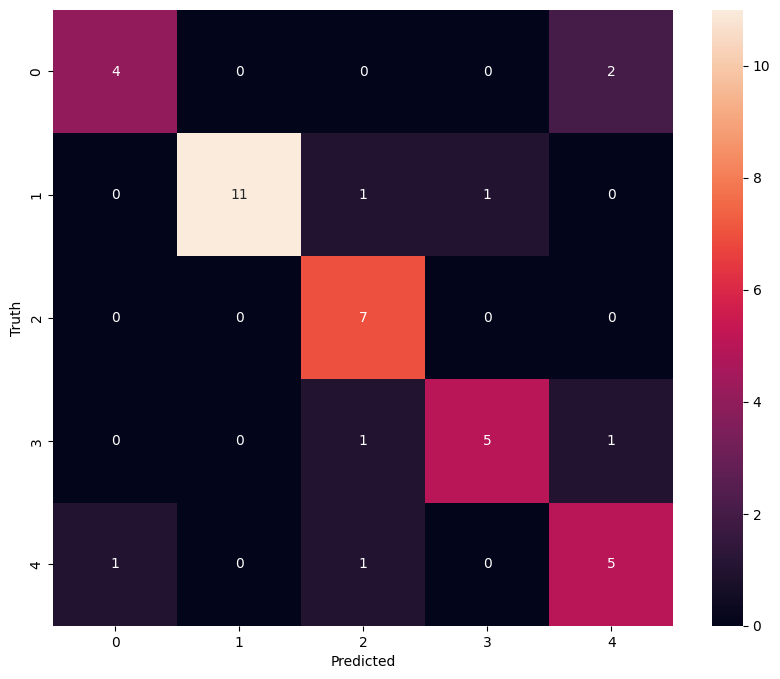

In [63]:
import seaborn as sn
plt.figure(figsize=(10,8))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [64]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [65]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))